<a href="https://colab.research.google.com/github/ikp-773/MRI-PD-Detection/blob/main/MRI_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [46]:
data_dir = '/content/drive/MyDrive/10_sliced_mri_dataset'

X = []
y = []

img_size=(256, 256)

num_slices = 10

for label, folder_name in enumerate(['control', 'parkinson']):
    folder_path = os.path.join(data_dir, folder_name)
    for subject in os.listdir(folder_path):

        subject_path = os.path.join(folder_path, subject)
        slices = []

        for img_name in sorted(os.listdir(subject_path)):
            img_path = os.path.join(subject_path, img_name)
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=img_size, color_mode='grayscale')
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            slices.append(img_array)

        slices = np.stack(slices, axis=0)
        X.append(slices)
        y.append(label)

X = np.array(X)
y = np.array(y)

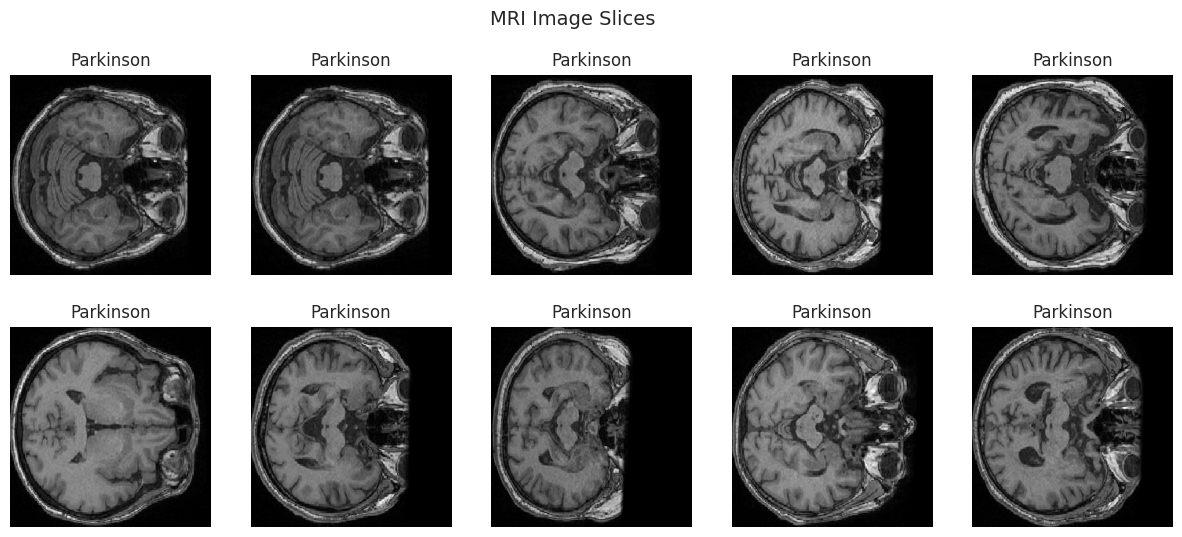

In [47]:
import seaborn as sns

sns.set_style("white")

def visualize_random_slices(X, y, rows=2, cols=5):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 6))
    fig.suptitle('MRI Image Slices', fontsize=14)
    for i in range(rows):
        for j in range(cols):
            index = np.random.randint(len(X))
            slice_index = np.random.randint(X.shape[1])
            axes[i, j].imshow(X[index, slice_index, :, :, 0], cmap='gray')
            axes[i, j].set_title('Control' if y[index] == 0 else 'Parkinson')
            axes[i, j].axis('off')
    plt.show()

visualize_random_slices(X, y)

In [73]:
X_1, X_test, y_1, y_test = train_test_split(X, y, test_size=0.1)

X_train, X_eval, y_train, y_eval = train_test_split(X_1, y_1, test_size=0.1)

# Normalize the data
X_train = X_train / 500.0
X_test = X_test / 500.0
X_eval = X_eval /500

In [74]:
print(y_test)

[1 0 0 1 0]


In [75]:
input_shape = X_train.shape[1:]

print(input_shape)

model = Sequential()

model.add(Conv3D(32, kernel_size=(2, 2, 2), activation='relu', input_shape=input_shape))
model.add(MaxPooling3D(pool_size=(1, 2, 3)))
model.add(BatchNormalization())

model.add(Conv3D(64, kernel_size=(2, 2, 2), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())

model.add(Conv3D(128, kernel_size=(2, 2, 2), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))

model.add(Dense(1, activation='sigmoid'))


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

(10, 256, 256, 1)


In [76]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_9 (Conv3D)           (None, 9, 255, 255, 32)   288       
                                                                 
 max_pooling3d_9 (MaxPooling  (None, 9, 127, 85, 32)   0         
 3D)                                                             
                                                                 
 batch_normalization_9 (Batc  (None, 9, 127, 85, 32)   128       
 hNormalization)                                                 
                                                                 
 conv3d_10 (Conv3D)          (None, 8, 126, 84, 64)    16448     
                                                                 
 max_pooling3d_10 (MaxPoolin  (None, 8, 63, 42, 64)    0         
 g3D)                                                            
                                                      

In [77]:
history = model.fit(X_train, y_train, epochs=10,validation_data=(X_eval, y_eval), batch_size=4)

Epoch 1/10
9/9 [==============================] - 172s 18s/step - loss: 102.3366 - accuracy: 0.4706 - val_loss: 2.1903 - val_accuracy: 0.5000
Epoch 2/10
9/9 [==============================] - 159s 18s/step - loss: 21.6546 - accuracy: 0.5588 - val_loss: 4.3143 - val_accuracy: 0.5000
Epoch 3/10
9/9 [==============================] - 157s 17s/step - loss: 17.3444 - accuracy: 0.7353 - val_loss: 1.6923 - val_accuracy: 0.5000
Epoch 4/10
9/9 [==============================] - 155s 17s/step - loss: 10.0324 - accuracy: 0.8235 - val_loss: 1.5873 - val_accuracy: 0.5000
Epoch 5/10
9/9 [==============================] - 156s 17s/step - loss: 8.0692 - accuracy: 0.8235 - val_loss: 6.9575 - val_accuracy: 0.5000
Epoch 6/10
9/9 [==============================] - 157s 17s/step - loss: 6.0584 - accuracy: 0.8824 - val_loss: 7.1126 - val_accuracy: 0.5000
Epoch 7/10
9/9 [==============================] - 159s 18s/step - loss: 3.7409 - accuracy: 0.9118 - val_loss: 16.6290 - val_accuracy: 0.5000
Epoch 8/10
9/9

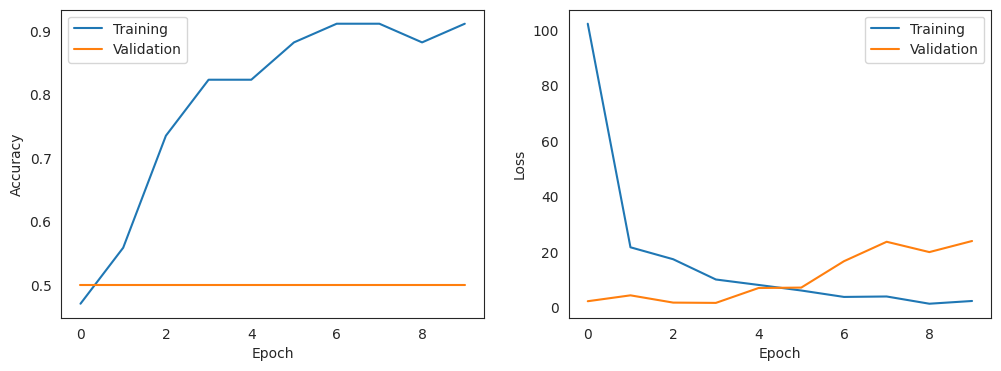

In [78]:

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.show()

resnet, googlenet, inception

In [81]:
loss, accuracy = model.evaluate(X_test, y_test)
print("Test accuracy:", accuracy)

1/1 [==============================] - 4s 4s/step - loss: 28.4383 - accuracy: 0.4000
Test accuracy: 0.4000000059604645


In [80]:
model.save('/content/drive/MyDrive/slice_mri_model')

KeyboardInterrupt: ignored

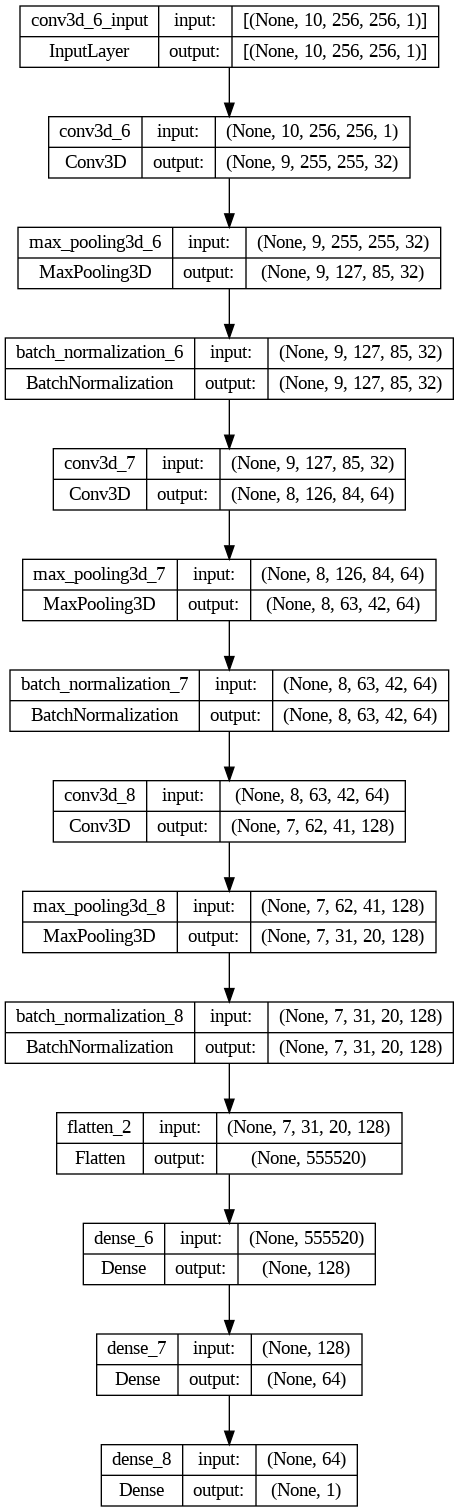

In [44]:
from keras.utils import plot_model

plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

1/1 [==============================] - 3s 3s/step


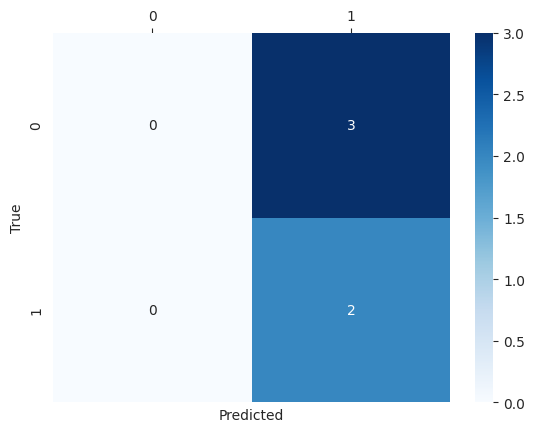

In [99]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)


y_true_classes = y_test  
# print(y_pred)
# print(y_pred_classes)
# print(y_true_classes)
# print(y_test)

# confusionmatrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

conf_mat = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
conf_mat.set(xlabel="Predicted", ylabel="True")

conf_mat.xaxis.tick_top()



In [96]:
print(y_pred_classes)
print(y_true_classes)

[[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]]
[1 1 0 1 0 1 0 1 1 0 1 1 1 0 0 1 1 1 1 1 0 1 0 1 1 1 1 1 0 1 0 1 0 1]
